In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import datetime
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from sklearn.linear_model import BayesianRidge, LinearRegression
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
run = 33 

av = xr.open_dataset('run%i/averages_00001102.nc' % run, decode_times=False)
sn = xr.open_dataset('run%i/snapshots_00001105.nc' % run, decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

filter_on = True
if filter_on:
    sigma = 16
coarsen_on = True
if coarsen_on:
    coarsen = 16

xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

In [4]:
def interp_u2_to_center(u):
    n,layers,ly,lx_p_1 = u.shape
    lx = lx_p_1 - 1
    u_center = np.zeros((n,layers,ly,lx))
    u_center[:,:,:,:] = (u[:,:,:,:-1] + u[:,:,:,1:])/2
    u_center[:,:,:,0] = (u[:,:,:,0] + u[:,:,:,-1])/2 # periodic
    u_center[:,:,:,-1] = (u[:,:,:,0] + u[:,:,:,-1])/2 # periodic
    
    return u_center
    
def interp_v2_to_center(v):
    n,layers,ly_p_1,lx = v.shape
    ly = ly_p_1 - 1
    v_center = np.zeros((n,layers,ly,lx))
    v_center[:,:,:,:] = (v[:,:,:-1,:] + v[:,:,1:,:])/2
    
    return v_center

def interp_to_center(A):
    n,layers,ly_p_1,lx_p_1 = A.shape
    ly = ly_p_1 - 1
    lx = lx_p_1 - 1
    A_center = np.zeros((n,layers,ly,lx))
    A_center[:,:,:,:] = (A[:,:,:-1,:-1] + A[:,:,1:,1:])/2 
    
    return A_center

In [5]:
def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    n,l,ly,lx = h.shape
    h_at_u = np.zeros((n,l,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    

def interp_h_to_v(h):
    """Interpolate h to the grid points where v is defined"""
    n,l,ly,lx = h.shape
    h_at_v = np.zeros((n,l,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v

In [6]:
def coarsen_h(h_fine):
    """It returns the 4 cell average of h when coarsen = 2"""
    n,l,ly,lx = h_fine.shape 
    hc_coarse = np.zeros((n,l,ly//coarsen,lx//coarsen))
    
    # Coarsening h to hc_coarse
    for j in range(coarsen):
        for i in range(coarsen):
            hc_coarse[:,:,:,:] = hc_coarse[:,:,:,:] + h_fine[:,:,j::coarsen,i::coarsen]
    
    return hc_coarse/(coarsen**2)

def project_h_to_fine(h_coarse):
    """It projects hc_coarse onto the fine grid"""
    n,l,ly_coarsen,lx_coarsen = h_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*lx_coarsen
    hc_fine = np.zeros((n,l,ly,lx))
    
    # Projecting hc_coarse onto the fine grid 
    for j in range(coarsen):
        for i in range(coarsen):
            hc_fine[:,:,j::coarsen,i::coarsen] = hc_coarse[:,:,:,:] 
   
    return hc_fine

def coarsen_u(u_fine):
    """It returns the mean over j"""
    n,l,ly,lx_p_1 = u_fine.shape 
    lx = lx_p_1 - 1
    uc_coarse = np.zeros((n,l,ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uc_coarse[:,:,:,:] = uc_coarse[:,:,:,:] + u_fine[:,:,j::coarsen,::coarsen]
    
    return uc_coarse/coarsen

def coarsen_hu(uh_fine):
    """It returns the sum over j"""
    n,l,ly,lx_p_1 = uh_fine.shape 
    lx = lx_p_1 - 1
    uhc_coarse = np.zeros((n,l,ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uhc_coarse[:,:,:,:] = uhc_coarse[:,:,:,:] + uh_fine[:,:,j::coarsen,::coarsen]
    
    return uhc_coarse

def project_u_to_fine(u_coarse):
    """It projects uc_coarse onto the fine grid"""
    n,l,ly_coarsen,lx_coarsen_p_1 = u_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*(lx_coarsen_p_1-1)
    uc_fine = np.zeros((n,l,ly,lx//coarsen+1))
    
    # Projecting onto the fine grid 
    for j in range(coarsen):
        uc_fine[:,:,j::coarsen,:] = u_coarse[:,:,:,:]
        
    return uc_fine

def coarsen_v(v_fine):
    """It returns the mean over i"""
    n,l,ly_p_1,lx = v_fine.shape 
    ly = ly_p_1 - 1
    vc_coarse = np.zeros((n,l,ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vc_coarse[:,:,:,:] = vc_coarse[:,:,:,:] + v_fine[:,:,::coarsen,i::coarsen]
    
    return vc_coarse/coarsen

def coarsen_hv(vh_fine):
    """It returns the sum over i"""
    n,l,ly_p_1,lx = vh_fine.shape 
    ly = ly_p_1 - 1
    vhc_coarse = np.zeros((n,l,ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vhc_coarse[:,:,:,:] = vhc_coarse[:,:,:,:] + vh_fine[:,:,::coarsen,i::coarsen]
    
    return vhc_coarse

def project_v_to_fine(v_coarse):
    """It projects vc_coarse onto the fine grid"""
    n,l,ly_coarsen_p_1,lx_coarsen = v_coarse.shape 
    ly,lx = coarsen*(ly_coarsen_p_1-1),coarsen*lx_coarsen
    vc_fine = np.zeros((n,l,ly//coarsen+1,lx))
    
    # Projecting onto the fine grid 
    for i in range(coarsen):
        vc_fine[:,:,:,i::coarsen] = v_coarse[:,:,:,:]
        
    return vc_fine

def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    n,l,ly,lx = h.shape
    h_at_u = np.zeros((n,l,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    """Interpolate h to the grid points where v is defined"""
    n,l,ly,lx = h.shape
    h_at_v = np.zeros((n,l,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v
    
def calc_hc_uc(hc,uc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_u = interp_h_to_u(hc_fine)
    uc_fine = project_u_to_fine(uc_coarse)
    
    return h_at_u[:,:,:,::coarsen]*uc_fine

def calc_hc_vc(hc,vc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_v = interp_h_to_v(hc_fine)
    vc_fine = project_v_to_fine(vc_coarse)
    
    return h_at_v[:,:,::coarsen,:]*vc_fine

def sum_j_direction(hu):
    n,l,ly,lx_p_1 = hu.shape 
    lx = lx_p_1 - 1
    hu_coarse = np.zeros((n,l,ly//coarsen,lx+1))
    
    for j in range(coarsen):
        hu_coarse[:,:,:,:] = hu_coarse[:,:,:,:] + hu[:,:,j::coarsen,:]
    
    return hu_coarse

def sum_i_direction(hv):
    n,l,ly_p_1,lx = hv.shape 
    ly = ly_p_1 - 1
    hv_coarse = np.zeros((n,l,ly+1,lx//coarsen))
    
    for i in range(coarsen):
        hv_coarse[:,:,:,:] = hv_coarse[:,:,:,:] + hv[:,:,:,i::coarsen]
    
    return hv_coarse

In [7]:
sn.u.shape

(20, 15, 4480, 1921)

In [8]:
N = len(av.time)
L = len(av.zl)

time = sn.time
zl = sn.zl
uh = np.zeros(sn.u.shape)
vh = np.zeros(sn.v.shape)
u = np.zeros(sn.u.shape)
v = np.zeros(sn.v.shape)
h = np.zeros(sn.h.shape)

uh = interp_h_to_u(sn.h.values)*sn.u.values
vh = interp_h_to_v(sn.h.values)*sn.v.values
h = sn.h.values
u = sn.u.values
v = sn.v.values

e = sn.h[:,::-1].cumsum(axis=1)[:,::-1] - st.depth_ocean

e = e.values

In [9]:
if filter_on:
        
    dyCu = st.dyCu
    dxCu = st.dxCu
    dyCv = st.dyCv
    dxCv = st.dxCv
    area_t = st.area_t
    
    hpup = np.zeros(sn.u.shape)
    hpvp = np.zeros(sn.v.shape)
    
    uh = gaussian_filter(uh,[0,0,sigma,sigma])
    vh = gaussian_filter(vh,[0,0,sigma,sigma])
    h = gaussian_filter(h,[0,0,sigma,sigma])
    u = gaussian_filter(u,[0,0,sigma,sigma])
    v = gaussian_filter(v,[0,0,sigma,sigma])
    
    hpup = uh - interp_h_to_u(h)*u
    hpvp = vh - interp_h_to_v(h)*v

    sum_hpup = hpup[:,::-1].cumsum(axis=1)[:,::-1] 
    sum_hpvp = hpvp[:,::-1].cumsum(axis=1)[:,::-1] 

In [10]:
hpup.shape

(20, 15, 4480, 1921)

In [11]:
if coarsen_on:
    n,l,ly,lx_p_1 = sn.u.shape
    ly = ly//coarsen
    lx_p_1 = lx_p_1//coarsen + 1
    ly_p_1 = ly + 1
    lx = lx_p_1 - 1
    hc_coarse = coarsen_h(h)
    ec_coarse = coarsen_h(e)
    uc_coarse = coarsen_u(u)
    uhc_coarse = coarsen_hu(uh)
    vc_coarse = coarsen_v(v)
    vhc_coarse = coarsen_hv(vh)
    
    hcuc_semi_fine = calc_hc_uc(hc_coarse,uc_coarse) 
    hcuc = sum_j_direction(hcuc_semi_fine) 

    hpup = uhc_coarse - hcuc
    
    hcvc_semi_fine = calc_hc_vc(hc_coarse,vc_coarse) 
    hcvc = sum_i_direction(hcvc_semi_fine) 

    hpvp = vhc_coarse - hcvc
    
    xh = st.xh.values[::coarsen]
    yh = st.yh.values[::coarsen]
    xq = st.xq.values[::coarsen]
    yq = st.yq.values[::coarsen]
    
    ly,lx = st.area_t.shape 
    area_t = st.area_t.values.astype(float).reshape((ly//coarsen,coarsen,lx//coarsen,coarsen)).sum(axis=-1).sum(axis=1) 
    dxCu = coarsen_hu(st.dxCu.values.reshape(1,1,ly,lx+1))
    dyCu = coarsen_hu(st.dyCu.values.reshape(1,1,ly,lx+1))
    dxCv = coarsen_hv(st.dxCv.values.reshape(1,1,ly+1,lx)) 
    dyCv = coarsen_hv(st.dyCv.values.reshape(1,1,ly+1,lx)) 
    dxCu = dxCu[0,0,:,:]
    dyCu = dyCu[0,0,:,:]
    dxCv = dxCv[0,0,:,:]
    dyCv = dyCv[0,0,:,:]
    
    h = hc_coarse
    e = ec_coarse
    sum_hpup = hpup[:,::-1].cumsum(axis=1)[:,::-1] 
    sum_hpvp = hpvp[:,::-1].cumsum(axis=1)[:,::-1] 

In [12]:
sum_hpup.shape

(20, 15, 280, 121)

In [13]:
dsc = xr.Dataset({'sum_uphp': (('time','zl','yh','xq'), sum_hpup), 
                  'sum_vphp': (('time','zl','yq','xh'), sum_hpvp),
                  'e': (('time','zl','yh','xh'), e),
                  'h': (('time','zl','yh','xh'), h),
                  'dxCu': (('yh','xq'), dxCu),
                  'dyCu': (('yh','xq'), dyCu),
                  'dxCv': (('yq','xh'), dxCv),
                  'dyCv': (('yq','xh'), dyCv),
                  'area_t': (('yh','xh'), area_t)})
dsc = dsc.assign_coords({'time':('time', time), 'zl':('zl', zl), 'yh': ('yh', yh), 'yq':('yq', yq), 'xh': ('xh', xh), 'xq': ('xq', xq)}) 
grid = Grid(dsc, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

In [14]:
dsc

<xarray.Dataset>
Dimensions:   (time: 20, xh: 120, xq: 121, yh: 280, yq: 281, zl: 15)
Coordinates:
  * time      (time) float64 1.105e+03 1.11e+03 1.115e+03 ... 1.195e+03 1.2e+03
  * zl        (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * yh        (yh) float64 -69.98 -69.48 -68.98 -68.48 ... 68.52 69.02 69.52
  * yq        (yq) float64 -70.0 -69.5 -69.0 -68.5 -68.0 ... 68.5 69.0 69.5 70.0
  * xh        (xh) float64 0.01562 0.5156 1.016 1.516 ... 58.52 59.02 59.52
  * xq        (xq) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 58.0 58.5 59.0 59.5 60.0
Data variables:
    sum_uphp  (time, zl, yh, xq) float64 nan nan nan nan nan ... nan nan nan nan
    sum_vphp  (time, zl, yq, xh) float64 nan nan nan nan nan ... nan nan nan nan
    e         (time, zl, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan
    h         (time, zl, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan
    dxCu      (yh, xq) float64 1.926e+04 1.926e+04 ... 1.926e+04 1.926e+04
    dyCu      (yh, xq) float64 5.566e+04 5.566e+04 ... 5.566e+04 5.566e+04
    dxCv      (yq, xh) float64 1.904e+04 1.904e+04 ... 1.904e+04 1.904e+04
    dyCv      (yq, xh) float64 5.566e+04 5.566e+04 ... 5.566e+04 5.566e+04
    area_t    (yh, xh) float64 1.072e+09 1.072e+09 ... 1.072e+09 1.072e+09

# Gent McWilliams (1990, 1995)

In [15]:
LHS = - grid.diff(dsc.sum_uphp * dsc.dyCu, 'X', boundary='fill') - grid.diff(dsc.sum_vphp * dsc.dxCv, 'Y', boundary='fill') # m^3/s
LHS = LHS/dsc.area_t #m/s

In [16]:
RHS = grid.diff(grid.diff(dsc.e, 'X', boundary='fill')*dsc.dyCu/dsc.dxCu,'X', boundary='fill') + grid.diff(grid.diff(dsc.e, 'Y', boundary='fill')*dsc.dxCv/dsc.dyCv, 'Y', boundary='fill') #m
RHS = RHS/dsc.area_t #1/m

In [17]:
LHS.shape

(20, 15, 280, 120)

In [18]:
crop = False
layers = np.arange(3,13,1)
if crop:
    lat_i = -65
    lat_f = 65
    lon_i = 5
    lon_f = 55

    lhs = LHS.sel(xh=slice(lon_i,lon_f),yh=slice(lat_i,lat_f))
    rhs = RHS.sel(xh=slice(lon_i,lon_f),yh=slice(lat_i,lat_f))
    lhs = lhs.where(dsc.e < -100)[:,layers]
    rhs = rhs.where(dsc.e < -100)[:,layers]
    lhs = lhs.where(dsc.h > 0.01)
    rhs = rhs.where(dsc.h > 0.01)
    rhs = rhs.where(abs(lhs) > 1e-7*np.nanmax(lhs))
    lhs = lhs.where(abs(lhs) > 1e-7*np.nanmax(lhs))
else:
    lhs = LHS.where(dsc.e < -100)[:,layers]
    rhs = RHS.where(dsc.e < -100)[:,layers]
    lhs = lhs.where(dsc.h > 0.01)
    rhs = rhs.where(dsc.h > 0.01)
    rhs = rhs.where(abs(lhs) > 1e-7*np.nanmax(lhs))
    lhs = lhs.where(abs(lhs) > 1e-7*np.nanmax(lhs))

In [19]:
def plot_box(lat_i,lat_f,lon_i,lon_f):
    plt.plot([lon_i,lon_f],[lat_i,lat_i],'k-')
    plt.plot([lon_i,lon_f],[lat_f,lat_f],'k-')
    plt.plot([lon_i,lon_i],[lat_i,lat_f],'k-')
    plt.plot([lon_f,lon_f],[lat_i,lat_f],'k-')

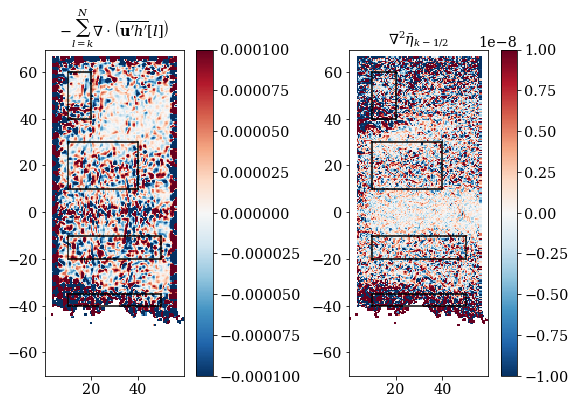

In [20]:
plt.figure(figsize=(10,6))

layer_no = 5
layer = layer_no - layers[0]

box1 = [40, 60, 10, 20]
box2 = [10, 30, 10, 40]
box3 = [-20, -10, 10, 50]
box4 = [-40, -35, 10, 50]

plt.subplot(1,2,1)
if crop:
    plt.pcolormesh(dsc.xh.sel(xh=slice(lon_i,lon_f)),dsc.yh.sel(yh=slice(lat_i,lat_f)),lhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
else:
    plt.pcolormesh(dsc.xh,dsc.yh,lhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])
plot_box(box3[0],box3[1],box3[2],box3[3])
plot_box(box4[0],box4[1],box4[2],box4[3])
plt.colorbar()
plt.clim((-1e-4,1e-4))
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}[l] \right)$')

plt.subplot(1,2,2)
if crop:
    plt.pcolormesh(dsc.xh.sel(xh=slice(lon_i,lon_f)),dsc.yh.sel(yh=slice(lat_i,lat_f)),rhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
else:
    plt.pcolormesh(dsc.xh,dsc.yh,rhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])
plot_box(box3[0],box3[1],box3[2],box3[3])
plot_box(box4[0],box4[1],box4[2],box4[3])
plt.colorbar()
plt.clim((-1e-8,1e-8))
plt.title(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('GM1.png', dpi=200,bbox_inches='tight',pad_inches=0)

[666.28545564]
[943.34044093]
[1179.83842752]
[2622.58019758]


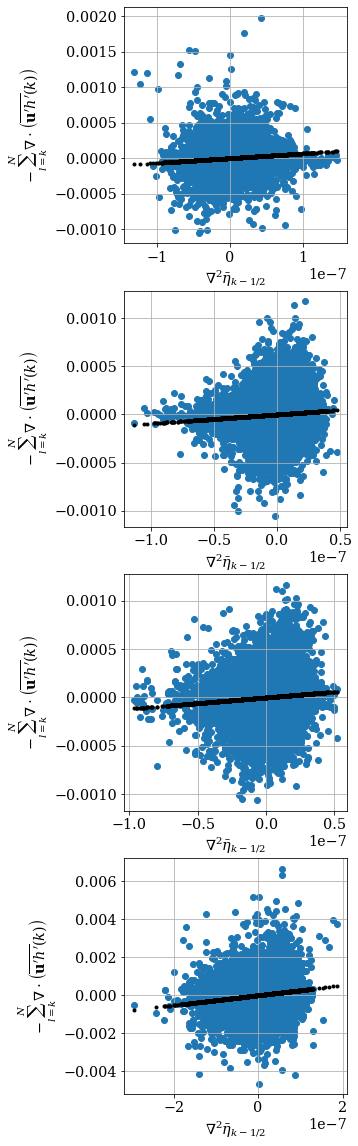

In [21]:
plt.figure(figsize=(4,20))

lhs_scatter = lhs.sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1]))
rhs_scatter = rhs.sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1]))
plt.subplot(4,1,1)
plt.scatter(rhs_scatter,lhs_scatter)
plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.grid()

X = rhs_scatter.values.flatten()
Y = lhs_scatter.values.flatten()
mask = ~np.isnan(X) & ~np.isnan(Y)
X = X[mask]
Y = Y[mask]
clf = BayesianRidge().fit(X.reshape(-1, 1),Y.reshape(-1, 1))
print(clf.coef_)
plt.plot(X,X*clf.coef_,'k.')

lhs_scatter = lhs.sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1]))
rhs_scatter = rhs.sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1]))
plt.subplot(4,1,2)
plt.scatter(rhs_scatter,lhs_scatter)
plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.grid()

X = rhs_scatter.values.flatten()
Y = lhs_scatter.values.flatten()
mask = ~np.isnan(X) & ~np.isnan(Y)
X = X[mask]
Y = Y[mask]
clf = BayesianRidge().fit(X.reshape(-1, 1),Y.reshape(-1, 1))
print(clf.coef_)
plt.plot(X,X*clf.coef_,'k.')

lhs_scatter = lhs.sel(xh=slice(box3[2],box3[3]),yh=slice(box3[0],box3[1]))
rhs_scatter = rhs.sel(xh=slice(box3[2],box3[3]),yh=slice(box3[0],box3[1]))
plt.subplot(4,1,3)
plt.scatter(rhs_scatter,lhs_scatter)
plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.grid()

X = rhs_scatter.values.flatten()
Y = lhs_scatter.values.flatten()
mask = ~np.isnan(X) & ~np.isnan(Y)
X = X[mask]
Y = Y[mask]
clf = BayesianRidge().fit(X.reshape(-1, 1),Y.reshape(-1, 1))
print(clf.coef_)
plt.plot(X,X*clf.coef_,'k.')

beta = clf.coef_
X_save = X
Y_save = Y

lhs_scatter = lhs.sel(xh=slice(box4[2],box4[3]),yh=slice(box4[0],box4[1]))
rhs_scatter = rhs.sel(xh=slice(box4[2],box4[3]),yh=slice(box4[0],box4[1]))
plt.subplot(4,1,4)
plt.scatter(rhs_scatter,lhs_scatter)
plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.grid()

X = rhs_scatter.values.flatten()
Y = lhs_scatter.values.flatten()
mask = ~np.isnan(X) & ~np.isnan(Y)
X = X[mask]
Y = Y[mask]
clf = BayesianRidge().fit(X.reshape(-1, 1),Y.reshape(-1, 1))
print(clf.coef_)
plt.plot(X,X*clf.coef_,'k.')

plt.savefig('GM2.png', dpi=200,bbox_inches='tight',pad_inches=0)

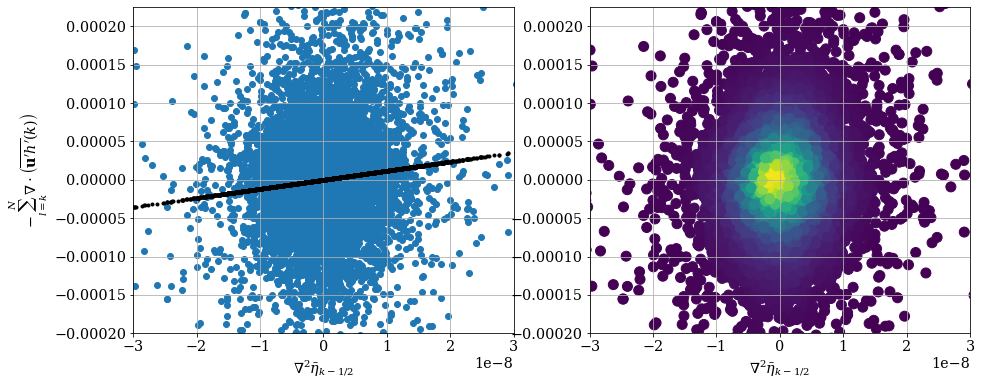

In [22]:
X = X_save
Y = Y_save

i = np.random.choice(len(X), 10000)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(X[i],Y[i])
plt.ylim((-0.00005*4,0.000075*3))
plt.xlim((-3e-8,3e-8))
plt.plot(X[i],X[i]*beta,'k.')
plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.grid()

plt.subplot(1,2,2)
xy = np.vstack([X[i],Y[i]])
z = gaussian_kde(xy)(xy)
plt.ylim((-0.00005*4,0.000075*3))
plt.xlim((-3e-8,3e-8))
plt.scatter(X[i], Y[i], c=z, s=100, edgecolor='face')
# plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
plt.grid()

(-0.00016, 0.00016)

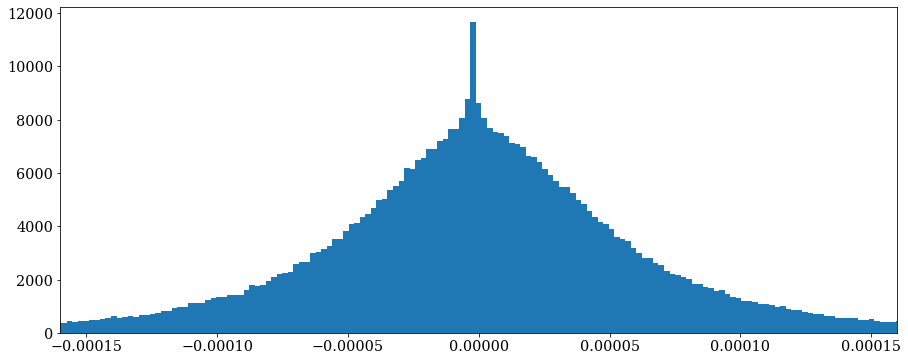

In [23]:
plt.figure(figsize=(15,6))
a = X*beta
b = Y
plt.hist(a-b,bins='auto',density=True);
plt.xlim((-0.00004*4,0.00004*4))

In [24]:
run = [20,26,28,33]

av1 = xr.open_dataset('run%i/averages_00030002.nc' % run[0], decode_times=False)
av2 = xr.open_dataset('run%i/averages_00030002.nc' % run[1], decode_times=False)
av3 = xr.open_dataset('run%i/averages_00030002.nc' % run[2], decode_times=False)
av4 = xr.open_dataset('run%i/averages_00001102.nc' % run[3], decode_times=False)

st1 = xr.open_dataset('run%i/static.nc' % run[0], decode_times=False)
st2 = xr.open_dataset('run%i/static.nc' % run[1], decode_times=False)
st3 = xr.open_dataset('run%i/static.nc' % run[2], decode_times=False)
st4 = xr.open_dataset('run%i/static.nc' % run[3], decode_times=False)

In [25]:
eta1 = av1.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta1 = eta1.mean(axis=0)

eta2 = av2.h[:,::-1].cumsum(axis=1)[:,::-1] - st2.depth_ocean
eta2 = eta2.mean(axis=0)

eta3 = av3.h[:,::-1].cumsum(axis=1)[:,::-1] - st3.depth_ocean
eta3 = eta3.mean(axis=0)

eta4 = av4.h[:,::-1].cumsum(axis=1)[:,::-1] - st4.depth_ocean
eta4 = eta4.mean(axis=0)

In [26]:
box1 = [55, 60, 7, 12]
box2 = [25, 30, 7, 12]

In [27]:
i = 0
PG1 = eta1[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta1[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG2 = eta2[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta2[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG3 = eta3[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta3[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG4 = eta4[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta4[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()

In [28]:
ACC1 = np.nansum(av1.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
ACC2 = np.nansum(av2.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
ACC3 = np.nansum(av3.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
ACC4 = np.nansum(av4.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6

In [29]:
ACC1

242.722864

In [30]:
PG_res = [PG1.values,PG2.values,PG3.values,PG4.values]
ACC_res = [ACC1, ACC2, ACC3, ACC4]
res = [4, 8, 16, 32]

In [31]:
av1 = xr.open_dataset('runGM/run1/averages_00030002.nc', decode_times=False)
sn1 = xr.open_dataset('runGM/run1/snapshots_00030005.nc', decode_times=False)
os1 = xr.open_dataset('runGM/run1/ocean.stats.nc', decode_times=False)
st1 = xr.open_dataset('runGM/run1/static.nc', decode_times=False)

av2 = xr.open_dataset('runGM/run2/averages_00030002.nc', decode_times=False)
sn2 = xr.open_dataset('runGM/run2/snapshots_00030005.nc', decode_times=False)
os2 = xr.open_dataset('runGM/run2/ocean.stats.nc', decode_times=False)

av3 = xr.open_dataset('runGM/run3/averages_00030002.nc', decode_times=False)
sn3 = xr.open_dataset('runGM/run3/snapshots_00030005.nc', decode_times=False)
os3 = xr.open_dataset('runGM/run3/ocean.stats.nc', decode_times=False)

av4 = xr.open_dataset('runGM/run4/averages_00030002.nc', decode_times=False)
sn4 = xr.open_dataset('runGM/run4/snapshots_00030005.nc', decode_times=False)
os4 = xr.open_dataset('runGM/run4/ocean.stats.nc', decode_times=False)

av5 = xr.open_dataset('runGM/run5/averages_00030002.nc', decode_times=False)
sn5 = xr.open_dataset('runGM/run5/snapshots_00030005.nc', decode_times=False)
os5 = xr.open_dataset('runGM/run5/ocean.stats.nc', decode_times=False)

av6 = xr.open_dataset('runGM/run6/averages_00030002.nc', decode_times=False)
sn6 = xr.open_dataset('runGM/run6/snapshots_00030005.nc', decode_times=False)
os6 = xr.open_dataset('runGM/run6/ocean.stats.nc', decode_times=False)

av7 = xr.open_dataset('runGM/run7/averages_00030002.nc', decode_times=False)
sn7 = xr.open_dataset('runGM/run7/snapshots_00030005.nc', decode_times=False)
os7 = xr.open_dataset('runGM/run7/ocean.stats.nc', decode_times=False)

av = xr.open_dataset('run33/averages_00001102.nc', decode_times=False)
os = xr.open_dataset('run33/ocean.stats.nc', decode_times=False)
st = xr.open_dataset('run34/static.nc', decode_times=False)

In [32]:
eta = av.h[:,::-1].cumsum(axis=1)[:,::-1] - st.depth_ocean
eta_ref = np.zeros((av1.h.shape))

In [33]:
N = len(av.time)
L = len(av.zl)
xlen = len(av.xh)
ylen = len(av.yh)

coarsen = 16

temp_eta = gaussian_filter(eta.values,[0,0,sigma,sigma])
eta_ref = coarsen_h(temp_eta)
        
eta_ref = eta_ref.mean(axis=0)

In [34]:
eta1 = av1.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta2 = av2.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta3 = av3.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta4 = av4.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta5 = av5.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta6 = av6.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean
eta7 = av7.h[:,::-1].cumsum(axis=1)[:,::-1] - st1.depth_ocean

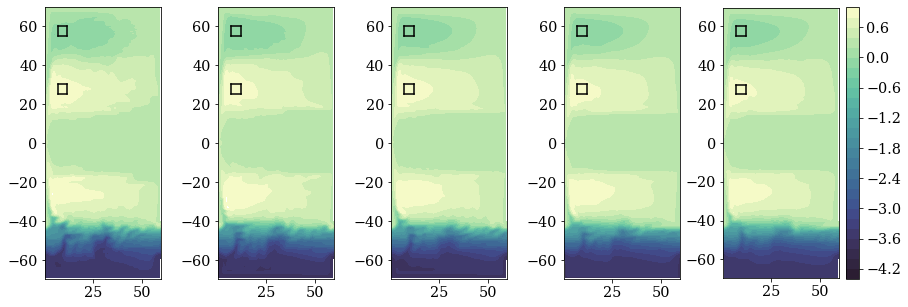

In [35]:
time = av1.time
l = 0
cmin = min(np.nanmin(eta1[:,l]),np.nanmin(eta2[:,l]),np.nanmin(eta3[:,l]),np.nanmin(eta4[:,l]),np.nanmin(eta5[:,l]))
cmax = max(np.nanmax(eta1[:,l]),np.nanmax(eta2[:,l]),np.nanmax(eta3[:,l]),np.nanmax(eta4[:,l]),np.nanmax(eta5[:,l]))
ci = np.arange(round(cmin)-0.4,round(cmax)+0.2,0.2)

for i in range(1): # range(len(time)) to create a video
    plt.figure(figsize=(15,5))
    plt.subplot(1,5,1)
    plt.contourf(st1.xh,st1.yh,eta1[i,l],cmap=cmocean.cm.deep_r,levels=ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plot_box(box1[0],box1[1],box1[2],box1[3])
    plot_box(box2[0],box2[1],box2[2],box2[3])

    plt.subplot(1,5,2)
    plt.contourf(st1.xh,st1.yh,eta2[i,l],cmap=cmocean.cm.deep_r,levels=ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plot_box(box1[0],box1[1],box1[2],box1[3])
    plot_box(box2[0],box2[1],box2[2],box2[3])

    plt.subplot(1,5,3)
    plt.contourf(st1.xh,st1.yh,eta3[i,l],cmap=cmocean.cm.deep_r,levels=ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plot_box(box1[0],box1[1],box1[2],box1[3])
    plot_box(box2[0],box2[1],box2[2],box2[3])

    plt.subplot(1,5,4)
    plt.contourf(st1.xh,st1.yh,eta4[i,l],cmap=cmocean.cm.deep_r,levels=ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plot_box(box1[0],box1[1],box1[2],box1[3])
    plot_box(box2[0],box2[1],box2[2],box2[3])

    plt.subplot(1,5,5)
    plt.contourf(st1.xh,st1.yh,eta5[i,l],cmap=cmocean.cm.deep_r,levels=ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plot_box(box1[0],box1[1],box1[2],box1[3])
    plot_box(box2[0],box2[1],box2[2],box2[3])
    plt.colorbar()
    
    save_name = 'SSH5/fig_'+'{0:06}'.format(int(time[i]))+ '.png'
    plt.savefig(save_name, dpi=200,bbox_inches='tight',pad_inches=0)
#     plt.close() # uncomment if saving multiple files

In [36]:
eta1 = eta1.mean(axis=0)
eta2 = eta2.mean(axis=0)
eta3 = eta3.mean(axis=0)
eta4 = eta4.mean(axis=0)
eta5 = eta5.mean(axis=0)
eta6 = eta6.mean(axis=0)
eta7 = eta7.mean(axis=0)

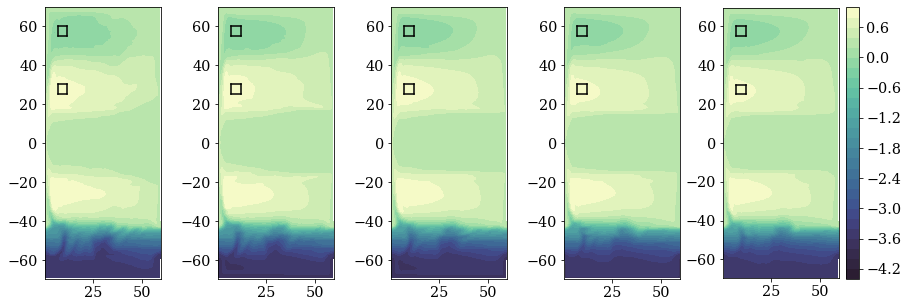

In [37]:
plt.figure(figsize=(15,5))

i = 0

cmin = min(np.nanmin(eta1[i]),np.nanmin(eta2[i]),np.nanmin(eta3[i]),np.nanmin(eta4[i]),np.nanmin(eta5[i]))
cmax = max(np.nanmax(eta1[i]),np.nanmax(eta2[i]),np.nanmax(eta3[i]),np.nanmax(eta4[i]),np.nanmax(eta5[i]))
ci = np.arange(round(cmin)-0.4,round(cmax)+0.2,0.2)

plt.subplot(1,5,1)
plt.contourf(st1.xh,st1.yh,eta1[i],cmap=cmocean.cm.deep_r,levels=ci)
plt.gca().set_aspect('equal', adjustable='box')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])

plt.subplot(1,5,2)
plt.contourf(st1.xh,st1.yh,eta2[i],cmap=cmocean.cm.deep_r,levels=ci)
plt.gca().set_aspect('equal', adjustable='box')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])

plt.subplot(1,5,3)
plt.contourf(st1.xh,st1.yh,eta3[i],cmap=cmocean.cm.deep_r,levels=ci)
plt.gca().set_aspect('equal', adjustable='box')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])

plt.subplot(1,5,4)
plt.contourf(st1.xh,st1.yh,eta4[i],cmap=cmocean.cm.deep_r,levels=ci)
plt.gca().set_aspect('equal', adjustable='box')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])

plt.subplot(1,5,5)
plt.contourf(st1.xh,st1.yh,eta5[i],cmap=cmocean.cm.deep_r,levels=ci)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plot_box(box1[0],box1[1],box1[2],box1[3])
plot_box(box2[0],box2[1],box2[2],box2[3])

plt.savefig('interface_height_%i.png' % i, dpi=200,bbox_inches='tight',pad_inches=0)

Calculate the pressure gradient force (PG) between the gyres on the Western Boundary as being approximately equal to the difference in interface height between the two boxes shown above.

In [38]:
PG1 = eta1[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta1[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG2 = eta2[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta2[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG3 = eta3[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta3[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG4 = eta4[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta4[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG5 = eta5[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta5[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG6 = eta6[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta6[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()
PG7 = eta7[i].sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1])).mean()-eta7[i].sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1])).mean()

In [39]:
PG = [PG1.values,PG2.values,PG3.values,PG4.values,PG5.values,PG6.values,PG7.values]

In [40]:
kappa_GM = [100, 300, 500, 800, 1000, 2500, 5000]

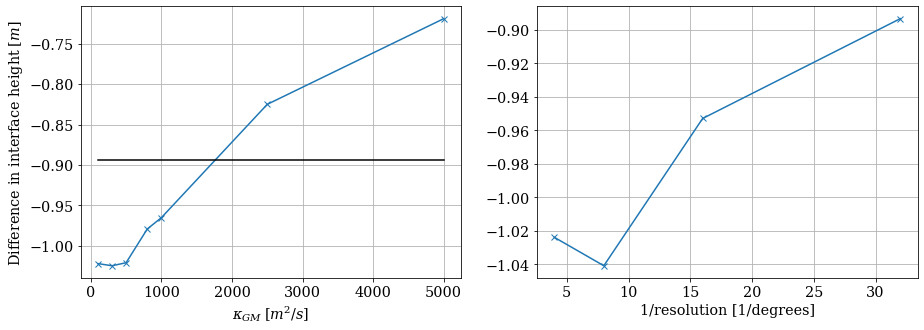

In [41]:
PG_ref = PG_res[3]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(kappa_GM,PG,'x-')
plt.plot(kappa_GM,PG_ref*np.ones(len(kappa_GM)),'k-')
plt.xlabel(r'$\kappa_{GM}\;[m^2/s]$')
plt.ylabel(r'Difference in interface height$\; [m]$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(res,PG_res,'x-')
plt.grid()
plt.xlabel('1/resolution [1/degrees]')

plt.savefig('difference_in_eta.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [42]:
e1 = (eta1 - eta_ref)**2
e2 = (eta2 - eta_ref)**2
e3 = (eta3 - eta_ref)**2
e4 = (eta4 - eta_ref)**2
e5 = (eta5 - eta_ref)**2
e6 = (eta6 - eta_ref)**2
e7 = (eta7 - eta_ref)**2

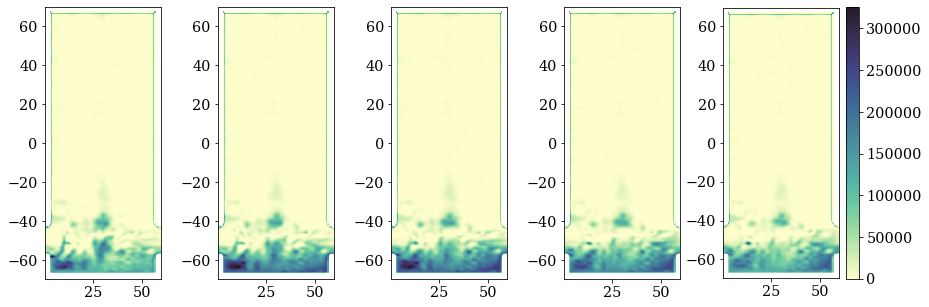

In [43]:
plt.figure(figsize=(15,5))

i = 10
cmax = np.nanmax(e3[i])
plt.subplot(1,5,1)
plt.pcolormesh(st1.xh,st1.yh,e1[i],cmap=cmocean.cm.deep)
plt.clim((0,cmax))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,5,2)
plt.pcolormesh(st1.xh,st1.yh,e2[i],cmap=cmocean.cm.deep)
plt.clim((0,cmax))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,5,3)
plt.pcolormesh(st1.xh,st1.yh,e3[i],cmap=cmocean.cm.deep)
plt.clim((0,cmax))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,5,4)
plt.pcolormesh(st1.xh,st1.yh,e4[i],cmap=cmocean.cm.deep)
plt.clim((0,cmax))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,5,5)
plt.pcolormesh(st1.xh,st1.yh,e5[i],cmap=cmocean.cm.deep)
plt.colorbar()
plt.clim((0,cmax))
plt.gca().set_aspect('equal', adjustable='box')

In [44]:
E = [e1.sum(), e2.sum(), e3.sum(), e4.sum(), e5.sum(), e6.sum(), e7.sum()]
APE = [os1.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum(), os2.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum(), os3.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum(), os4.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum(), os5.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum(), os6.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum(), os7.APE.sel(Time=slice(31500,32000)).mean(axis=0).sum()]

In [45]:
acc1 = np.nansum(av1.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
acc2 = np.nansum(av2.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
acc3 = np.nansum(av3.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
acc4 = np.nansum(av4.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
acc5 = np.nansum(av5.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
acc6 = np.nansum(av6.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
acc7 = np.nansum(av7.uh.sel(yh=slice(-60,-40),xq=0).mean(axis=0).values)/1e6
ACC = [acc1,acc2,acc3,acc4,acc5,acc6,acc7]
ACC_ref = ACC_res[3]

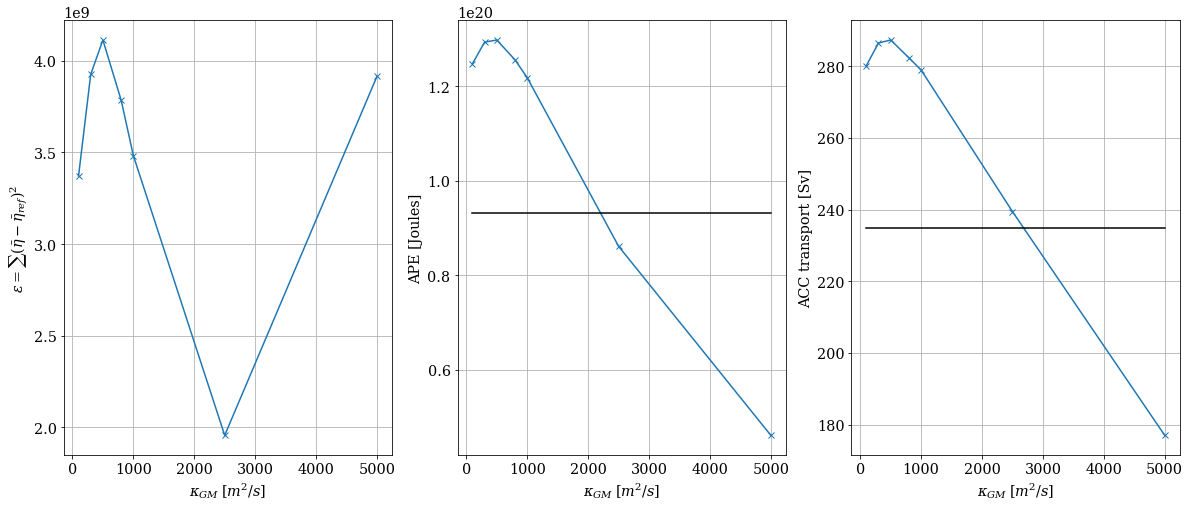

In [46]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(kappa_GM,E,'x-')
plt.xlabel(r'$\kappa_{GM}\;[m^2/s]$')
plt.ylabel(r'$\epsilon=\sum (\bar{\eta}-\bar{\eta}_{ref})^2$')
plt.grid()

plt.subplot(1,3,2)
plt.plot(kappa_GM,APE,'x-')
plt.plot(kappa_GM,(os.APE.sel(Time=slice(1000,1500)).mean(axis=0).sum().values)*np.ones(len(kappa_GM)),'k-')
plt.xlabel(r'$\kappa_{GM}\;[m^2/s]$')
plt.ylabel('APE [Joules]')
plt.grid()

plt.subplot(1,3,3)
plt.plot(kappa_GM,ACC,'x-')
plt.plot(kappa_GM,ACC_ref*np.ones(len(kappa_GM)),'k-')
plt.xlabel(r'$\kappa_{GM}\;[m^2/s]$')
plt.ylabel('ACC transport [Sv]')
plt.grid()

plt.savefig('GM4.png', dpi=200,bbox_inches='tight',pad_inches=0)

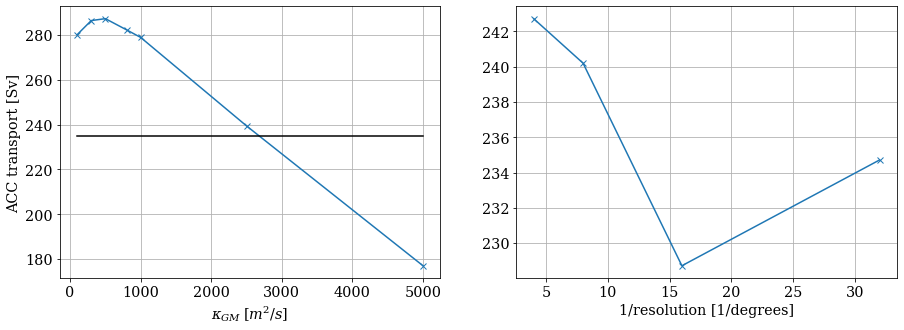

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(kappa_GM,ACC,'x-')
plt.plot(kappa_GM,ACC_ref*np.ones(len(kappa_GM)),'k-')
plt.xlabel(r'$\kappa_{GM}\;[m^2/s]$')
plt.ylabel(r'ACC transport [Sv]')
plt.grid()

plt.subplot(1,2,2)
plt.plot(res,ACC_res,'x-')
plt.grid()
plt.xlabel('1/resolution [1/degrees]')
plt.savefig('ACC_res.png', dpi=200,bbox_inches='tight',pad_inches=0)

# Visbeck et al. (1997)

$$\kappa_{GM} \sim \frac{1}{H}\int \frac{M^2}{N}\mathrm{d}z=\frac{1}{H} \int s_\rho N \mathrm{d}z$$

In [48]:
run = 28
os = xr.open_dataset('run%i/ocean.stats.nc' % run, decode_times=False)

In [51]:
s_rho = np.sqrt(interp_u2_to_center(((grid.diff(dsc.e, 'X', boundary='fill')/dsc.dxCu)**2).values) + interp_v2_to_center(((grid.diff(dsc.e, 'Y', boundary='fill')/dsc.dyCv)**2).values))
sNh = s_rho*np.sqrt(np.diff(os.Interface).reshape(1,15,1,1)*dsc.h)
k_visbeck = sNh*(interp_u2_to_center(dsc.dxCu.values.reshape(1,1,ly//coarsen,lx//coarsen+1)**2)+interp_v2_to_center(dsc.dyCv.values.reshape(1,1,ly//coarsen+1,lx//coarsen)**2))
k_visbeck = sNh.sum(axis=1)

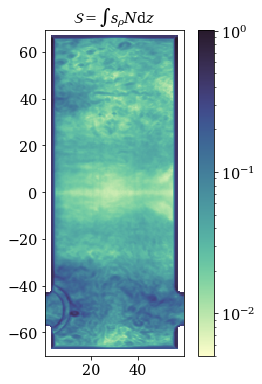

In [57]:
plt.figure(figsize=(5,6))
plt.title(r'$\mathcal{S}=\int s_\rho N \mathrm{d}z$')

plt.pcolormesh(dsc.xh,dsc.yh,k_visbeck.mean(axis=0), norm=colors.LogNorm(vmin=5e-3, vmax=np.nanmax(k_visbeck.mean(axis=0))), cmap=cmocean.cm.deep)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

# Danabasoglu et al. (2007)

$$\kappa_{GM} \sim \frac{N^2}{N_{ref}^2}\kappa_{ref}$$

In [58]:
# lhs = LHS.where(dsc.e < -100)[:,layers]
# rhs = N2[:,layers]*RHS.where(dsc.e < -100)[:,layers]

In [59]:
# plt.figure(figsize=(25,8))

# layer_no = 5
# layer = layer_no - layers[0]

# box1 = [40, 60, 10, 20]
# box2 = [10, 30, 10, 40]
# box3 = [-20, -10, 10, 50]
# box4 = [-40, -35, 10, 50]

# plt.subplot(1,6,1)
# if crop:
#     plt.pcolormesh(dsc.xh.sel(xh=slice(lon_i,lon_f)),dsc.yh.sel(yh=slice(lat_i,lat_f)),lhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
# else:
#     plt.pcolormesh(dsc.xh,dsc.yh,lhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
# plot_box(box1[0],box1[1],box1[2],box1[3])
# plot_box(box2[0],box2[1],box2[2],box2[3])
# plot_box(box3[0],box3[1],box3[2],box3[3])
# plot_box(box4[0],box4[1],box4[2],box4[3])
# plt.colorbar()
# plt.clim((-5e-6,5e-6))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.title(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}[l] \right)$')

# plt.subplot(1,6,2)
# if crop:
#     plt.pcolormesh(dsc.xh.sel(xh=slice(lon_i,lon_f)),dsc.yh.sel(yh=slice(lat_i,lat_f)),rhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
# else:
#     plt.pcolormesh(dsc.xh,dsc.yh,rhs[0,layer],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
# plot_box(box1[0],box1[1],box1[2],box1[3])
# plot_box(box2[0],box2[1],box2[2],box2[3])
# plot_box(box3[0],box3[1],box3[2],box3[3])
# plot_box(box4[0],box4[1],box4[2],box4[3])
# plt.colorbar()
# plt.clim((-5e-13,5e-13))
# plt.title(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
# plt.gca().set_aspect('equal', adjustable='box')

# lhs_scatter = lhs.sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1]))
# rhs_scatter = rhs.sel(xh=slice(box1[2],box1[3]),yh=slice(box1[0],box1[1]))
# plt.subplot(2,6,4)
# plt.scatter(rhs_scatter,lhs_scatter)
# plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
# plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
# plt.grid()

# lhs_scatter = lhs.sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1]))
# rhs_scatter = rhs.sel(xh=slice(box2[2],box2[3]),yh=slice(box2[0],box2[1]))
# plt.subplot(2,6,6)
# plt.scatter(rhs_scatter,lhs_scatter)
# plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
# plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
# plt.grid()

# lhs_scatter = lhs.sel(xh=slice(box3[2],box3[3]),yh=slice(box3[0],box3[1]))
# rhs_scatter = rhs.sel(xh=slice(box3[2],box3[3]),yh=slice(box3[0],box3[1]))
# plt.subplot(2,6,10)
# plt.scatter(rhs_scatter,lhs_scatter)
# plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
# plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
# plt.grid()

# lhs_scatter = lhs.sel(xh=slice(box4[2],box4[3]),yh=slice(box4[0],box4[1]))
# rhs_scatter = rhs.sel(xh=slice(box4[2],box4[3]),yh=slice(box4[0],box4[1]))
# plt.subplot(2,6,12)
# plt.scatter(rhs_scatter,lhs_scatter)
# plt.ylabel(r'$-\sum_{l=k}^{N} \nabla \cdot \left( \overline{\mathbf{u}^\prime h^\prime}(k) \right)$')
# plt.xlabel(r'$\nabla^2 \bar{\eta}_{k-1/2} $')
# plt.grid()

# plt.savefig('Danabasoglu.png', dpi=200,bbox_inches='tight',pad_inches=0)

# Checking the accuracy of our coarsening operator

In [60]:
def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    ly,lx = h.shape
    h_at_u = np.zeros((ly,lx+1))
    h_at_u[:,1:-1] = (h[:,:-1] + h[:,1:])/2
    h_at_u[:,0] = (h[:,0] + h[:,-1])/2 # periodic
    h_at_u[:,-1] = (h[:,0] + h[:,-1])/2 # periodic
    
    return h_at_u

def coarsen_h(h_fine):
    """It returns the 4 cell average of h when coarsen = 2"""
    ly,lx = h_fine.shape 
    hc_coarse = np.zeros((ly//coarsen,lx//coarsen))
    
    # Coarsening h to hc_coarse
    for j in range(coarsen):
        for i in range(coarsen):
            hc_coarse[:,:] = hc_coarse[:,:] + h_fine[j::coarsen,i::coarsen]
    
    return hc_coarse/(coarsen**2)

def coarsen_u(u_fine):
    """It returns the mean over j"""
    ly,lx_p_1 = u_fine.shape 
    lx = lx_p_1 - 1
    uc_coarse = np.zeros((ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uc_coarse[:,:] = uc_coarse[:,:] + u_fine[j::coarsen,::coarsen]
    
    return uc_coarse/coarsen

def coarsen_hu(uh_fine):
    """It returns the sum over j"""
    ly,lx_p_1 = uh_fine.shape 
    lx = lx_p_1 - 1
    uhc_coarse = np.zeros((ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uhc_coarse[:,:] = uhc_coarse[:,:] + uh_fine[j::coarsen,::coarsen]
    
    return uhc_coarse

def project_h_to_fine(h_coarse):
    """It projects hc_coarse onto the fine grid"""
    ly_coarsen,lx_coarsen = h_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*lx_coarsen
    hc_fine = np.zeros((ly,lx))
    
    # Projecting hc_coarse onto the fine grid 
    for j in range(coarsen):
        for i in range(coarsen):
            hc_fine[j::coarsen,i::coarsen] = hc_coarse[:,:] 
   
    return hc_fine

def project_u_to_fine(u_coarse):
    """It projects uc_coarse onto the fine grid"""
    ly_coarsen,lx_coarsen_p_1 = u_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*(lx_coarsen_p_1-1)
    uc_fine = np.zeros((ly,lx//coarsen+1))
    
    # Projecting onto the fine grid 
    for j in range(coarsen):
        uc_fine[j::coarsen,:] = u_coarse[:,:]
        
    return uc_fine

def calc_hc_uc(hc,uc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_u = interp_h_to_u(hc_fine)
    uc_fine = project_u_to_fine(uc_coarse)
    
    return h_at_u[:,::coarsen]*uc_fine

def sum_j_direction(hu):
    ly,lx_p_1 = hu.shape 
    lx = lx_p_1 - 1
    hu_coarse = np.zeros((ly//coarsen,lx+1))
    
    for j in range(coarsen):
        hu_coarse[:,:] = hu_coarse[:,:] + hu[j::coarsen,:]
    
    return hu_coarse

In [61]:
h = st.wet*0.0 + st.yh + 100
u = st.wet_u*0.0 + 2e-3*st.yh 

In [62]:
# yh_new = np.linspace(-70,70,560)
# yh_new = yh_new.reshape((560,1))

# h = np.zeros((560,240)) + yh_new + 100
# u = np.zeros((560,241)) + 2e-3*yh_new

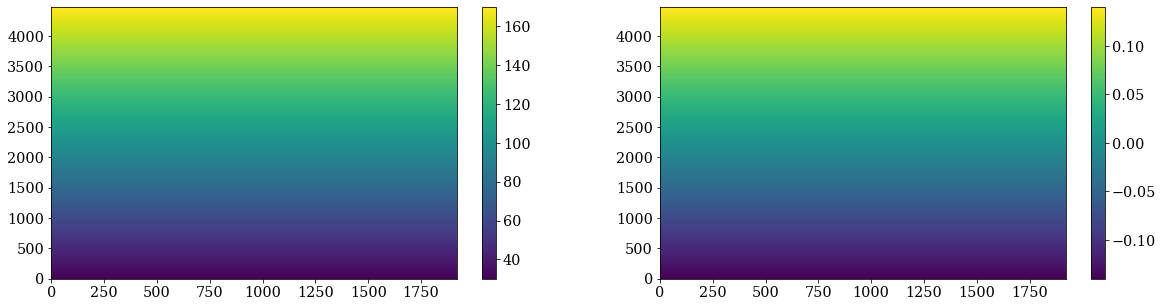

In [63]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.pcolormesh(h)
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(u)
plt.colorbar()

In [64]:
coarsen=2
hu = u*interp_h_to_u(h.values)

hc_coarse = coarsen_h(h) # m
uc_coarse = coarsen_u(u) # m/s
uhc_coarse = coarsen_hu(hu) # m^2/s
hcuc_semi_fine = calc_hc_uc(hc_coarse,uc_coarse) # m^2/s
hcuc = sum_j_direction(hcuc_semi_fine) # m^2/s

hpup = uhc_coarse - hcuc

In [65]:
# hpup = uhc_coarse - interp_h_to_u(hc_coarse)*uc_coarse*coarsen

In [66]:
hpup.shape

(2240, 961)

0.0

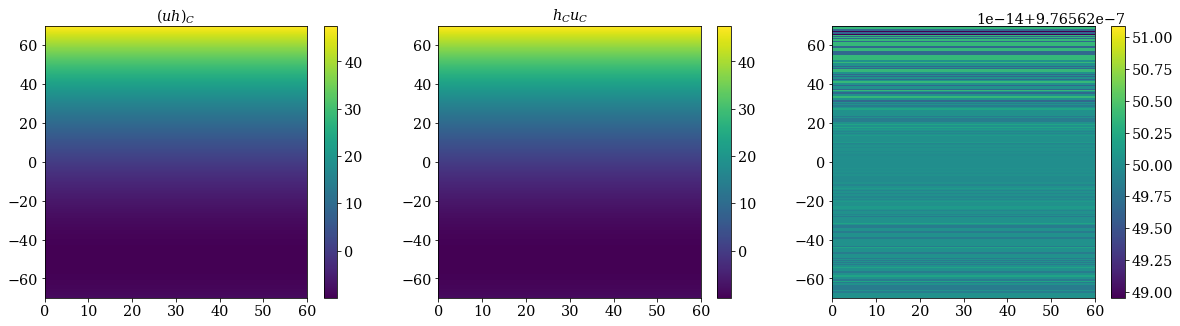

In [67]:
plt.figure(figsize=(20,5))
# plt.subplot(1,3,1)
# plt.pcolormesh(sn.xq[::coarsen],sn.yh[::coarsen],uhc_coarse)
# plt.colorbar()
# plt.title(r'$(uh)_C$')
# plt.subplot(1,3,2)
# plt.pcolormesh(sn.xq[::coarsen],sn.yh[::coarsen],hcuc)
# plt.title(r'$h_C u_C$')
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.pcolormesh(sn.xq[::coarsen],sn.yh[::coarsen],hpup)
# # plt.title(r'$(uh)_C-h_C u_C$')
# plt.colorbar()

plt.subplot(1,3,1)
plt.pcolormesh(sn.xq[::coarsen],sn.yh[::coarsen],uhc_coarse)
plt.colorbar()
plt.title(r'$(uh)_C$')
plt.subplot(1,3,2)
plt.pcolormesh(sn.xq[::coarsen],sn.yh[::coarsen],hcuc)
plt.title(r'$h_C u_C$')
plt.colorbar()
plt.subplot(1,3,3)
plt.pcolormesh(sn.xq[::coarsen],sn.yh[::coarsen],hpup)
# plt.title(r'$(uh)_C-h_C u_C$')
plt.colorbar()

plt.savefig('linear_operator_%i.png' %coarsen, dpi=200,bbox_inches='tight',pad_inches=0)

np.nanmin(hcuc-interp_h_to_u(hc_coarse)*uc_coarse*coarsen)

In [68]:
np.nanmax(hpup)

9.76562510857093e-07

In [69]:
np.nanmax(hpup)/np.nanmax(hcuc)

2.052895586852763e-08

In [70]:
1/2**4/2

0.03125

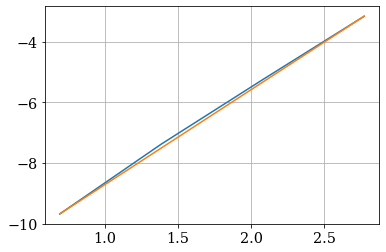

In [73]:
plt.plot(np.log([1,2,4,8,16]),np.log([0,0.0000625,6.25e-4,5.25e-3,4.25e-2]))
plt.plot(np.log([2,16]),np.log([6.25e-5,4.25e-2]),'-')
plt.grid()